In [ ]:
import numpy 
import matplotlib.pyplot as plt 
%matplotlib inline 
import scipy.integrate 
from scipy.integrate import solve_ivp
import scipy.optimize
import scipy.signal

# Blending Process Response

The liquid storage system shown has two inlet streams ($w_{1}$ and $w_{2}$) and an outlet stream ($w_{3}$). The tank is $\textbf{2.5 m high and 2 m}$ in diameter. The liquid density is $\textbf{800 kg/m3}$. You may assume that the density is constant. The nominal operating conditions are as follows:

$$ \bar{w_{1}} = 120 \ \mathrm{kg/min} $$

$$ \bar{w_{2}} = 100 \ \mathrm{kg/min} $$

The equations governing the dynamic behaviour of the system are as follows:

$$ \rho A \frac{dh}{dt} = w_{1} + w_{2} -w_{3}$$ 

$$ w_{3} = C_{v}\sqrt{h} $$

In addition it is known that there is leak located 1 m from the base of the tank. The volumetric flow rate of the leak is expected to be modelled with reasonable accuracy by the following equation:

$$ q = 0.025\sqrt{h-1} $$

You are now expected to simulate the above system in the time domain. This means you may not linearise and transform this system to the laplace domain. You may not make use of the control library. How you integrate the system is entirely up to you. $\textbf{Simulate the system for a rectangular wave input in $w_{1}$ with appropriate magnitude changes}$. 

Cameron has attempted to help you out however his python skills are not as good as he claims. He has clearly made some errors and would greatly appreciate your help! You will have to debug the code and produce the final plot.

#notes#

DO PID controller coding..needs to work 
Has to be a continuous system/PID.

Will have mre submission to come..must have markdown with discussion on things given in SG.

20%-Implementation of P,PI,PID controller ..have one but must easily distinguish different.
Can include noise/point of linearization. Will show how to do cont.,dead time and .

Fix some variables ..code not 100% working.


## Parameters  of the system

In [ ]:
rho = 800 # kg/m3
D = 2 # m
hmax = 2.5 #m
A = (numpy.pi/4)*(D**2) #m^2
Cv = 200
w1_ss = 120 # kg/min
w2_ss = 100 # kg/min

## Inputs to the system:

In [ ]:
def MV_w1(t):
    """
    THIS FUNCTION CAN BE ALTERED!
    The manipulated variable w1. The output of 
    this function varies with time.
    
    Parameters
    ----------
    t : float or integer
        Time.
        Units - [min]

    Returns
    -------
    w1 : float or integer
        The mass flowrate of the manipulated
        variable, w1.
        Units - [kg/min]
    """
    if t < 0:
        
        return w1_ss
    
    elif t < 10:
        
        return 120
    
    elif t >= 10 and t <125:
        
        return 125
    
    elif t >= 125:
        
        return w1_ss

def MV_w1_step(t):
    """
    THIS FUNCTION SHOULD NOT BE ALTERED!
    The manipulated variable w1. The output of 
    this function varies with time. This function
    should be used to fit the FOPDT model. 
    
    Parameters
    ----------
    t : float or integer
        Time.
        Units - [min]

    Returns
    -------
    w1 : float or integer
        The mass flowrate of the manipulated
        variable, w1.
        Units - [kg/min]
    """
    if t < 10:
        
        return w1_ss
    
    elif t >= 10:
        
        return w1_ss + M
    
    
def MV_w2(t):
    """
    THIS FUNCTION CAN BE ALTERED!
    The manipulated variable w2. The output of 
    this function varies with time.
    
    Parameters
    ----------
    t : float or integer
        Time.
        Units - [min]

    Returns
    -------
    w2 : float or integer
        The mass flowrate of the manipulated
        variable, w1.
        Units - [kg/min]
    """
    if t < 200:
        
        return w2_ss
    
    elif t >= 200:
        
        return 1.5*w2_ss

## The outputs from the system:

In [ ]:
def w3(h):
    """
    The mass flowrate out of the system which is a
    function of the height of the tank.
    
    Parameters
    ----------
    h : float or integer
        Height of the tank.
        Units - [m]
        
    Other Parameters
    ----------------
    CV: float or integer
        The flow coefficient of the valve.
        Units - [dimensionless]

    Returns
    -------
    w3 : float or integer
        The mass flowrate out of the system.
        Units - [kg/min]
    """
    return Cv*numpy.sqrt(h)
    
def w_leak(h):
    """
    The mass flowrate out of the system due to the leak
    which is a function of the height of the tank.
    
    Parameters
    ----------
    h : float or integer
        Height of the tank.
        Units - [m]
        
    Other Parameters
    ----------------
    q: float or integer
        The volumetric flowrate out of the tank.
        Units - [m^3/min]

    Returns
    -------
    w_leak : float or integer
        The mass flowrate out of the system due to the leak.
        Units - [kg/min]
    """
    if h < 1: # Liquid level is below the leak.
        
        q = 0
    
    else: # Liquid level is above the leak.
        q = 0.025 * numpy.sqrt(h - 1)
        
    return rho*q

## Differential and integration functions:

In [ ]:
def diff(t,var, fitting = False):
    """
    The function should contain all the differential 
    equations present in the system.
    
    Parameters
    ----------
    t : float or integer
        Time.
        Units - [min]
        
    var : iterable object or integer/float
        If there is more than one diffferential equation
        in the system, the var will be an iterable object.
        Otherwise, var is either an integer or a float.
        
        - h : float or integer 
            Units - [m]
            
    fitting: Boolean
        Default: False
        Determines whether model fitting on a step response of 
        one of the manipulated variables is being done or not.
            
    Other Parameters
    ----------------
    rho: float or integer
        The density of the fluid.
        Units - [kg/m^3]
        
    A: float or integer
        The cross-sectional area of the tank.
        Units - [m^2]

    Returns
    -------
    differential equations : iterable object
        All the changes in dependent variables, as described in
        var, with respect to time.
        
        - dh_dt:
            The change in liquid level in the tank per unit time. 
            If the system is empty or is overflowing, then it 
            returns 0.
            Units - [m]
    """
    h = var[0]
    
    if h <= 0 or h >= hmax: # Bondaries of the liquid level
        dhdt = 0
    
    else:
        w1 = MV_w1_step(t) if fitting else MV_w1(t)
        w2 = w2_ss if fitting else MV_w2(t)
        dhdt = (1/ (rho * A)) * (w1 + w2 - w_leak(h) - w3(h))
        
    return [dhdt]
    


def solve_diff_equations(tspan, y0, fitting = False):
    """
    Solves the differential equations in the diff function
    using Euler integration.
    
    Parameters
    ----------
    tspan : array
        An array of time values.
        Units - [min]
            
    y0 : array
        An array initial values.
        Units - depends on the variable.
        
    Returns
    -------
    - ans_matrix:
        The matrix containing the solution to each
        differentiable equation in the system.
        Units - depends on the variable
    """
    dt = tspan[1] - tspan[0] # The time steps
    ans_array = []
    y = y0
    
    for index, t in enumerate(tspan):
        ans_array.append(y)
        dydt = diff(t = t, var = y, fitting = fitting)
        y = []
        for i, value in enumerate(dydt):
            y.append(ans_array[-1][i] + value*dt)
            
    ans_matrix = numpy.array(ans_array).T

    return ans_matrix

## Steady-state function:

In [ ]:
def steady_state(y):
    """
    Calculates the change in liquid level in the tank with respet to 
    time when the manipulated variables are still at steady state. This
    function can be used with scipy.optimize.fsolve to solve the steady
    state values.
    
    Parameters
    ----------
    y : An iterable object
        These are all the dependent variables of the system of
        differential equations as described in the diff function.
        
        - h : float or integer 
            Units - [m]
        
    Returns
    -------
    differential equations : iterable object
        All the changes in dependent variables, as described in
        var, with respect to time.
        
        - dh_dt:
            The change in liquid level in the tank per unit time. 
            If the system is empty or is overflowing, then it 
            returns 0.
            Units - [m]
    """
    
    return diff(-1,y)

## Plotting Function

In [ ]:
def plot_function(t, y_values, y_labels, markers, labels = None, titles = None, fig_size = (10, 7), subplot = True):
    """
    Plot the desired graphs the user wants to display.
    
    Parameters
    ----------
    t : array
        An array of time values.
        Units - [min]
            
    y_values : A list of iterabe objects.
        The dependent values for each graph.
        Units - depends on the variable.
    
    y_labels : A list of strings.
        The y-axis labels for each graph.
    
    Markers : A list of strings.
        The marker that needs to be used for each plot.
        
    labels : A list of strings.
        Default: None
        The labels of each graph.

    titles : A list of strings.
        Default: None
        Returns a title for each plot. If no
        input is specified, then no titles will
        be added to each plot.
    
    fig_size : A tuple of integers.
        Default: (10, 7)
        The figure size.
    
    subplot : Boolean
        Default: True
        Whether or not a subplot should be made.
        
    Returns
    -------
    None
    """
    if subplot:
        fig, axes = plt.subplots(len(y_values),1, figsize = fig_size)

        for index, y in enumerate(y_values):
            axes[index].plot(t, y, markers[index])
            axes[index].set_xlabel(xlabel = "time (min)")
            axes[index].set_ylabel(ylabel = y_labels[index])
            if titles == None:
                pass
            else:
                axes[index].set_title(label = titles[index])

    
    else:
        for index, y in enumerate(y_values):
            plt.figure(num = titles, figsize = fig_size)
            plt.plot(tspan, y, markers[index], label = labels[index])
        plt.legend(loc = "best")
        plt.title(label = titles)
        plt.xlabel(xlabel = "Time (min)")
        plt.ylabel(ylabel = y_labels[0])
    
    plt.show()

Calculate the steady-state value of h

In [ ]:
h_ss_guess = [1.5]
h_ss = scipy.optimize.fsolve(func = steady_state, 
                             x0 = h_ss_guess)[0] 

print(f"h_ss = {h_ss} m")

h_ss = 1.1315282657727623 m


Integrate  

In [ ]:
tspan = numpy.linspace(0,300,1000)
h_array = solve_diff_equations(tspan = tspan,
                               y0 = [h_ss])[0]

MV_w1_array = numpy.array(list(map(MV_w1, tspan)))
MV_w2_array = numpy.array(list(map(MV_w2, tspan)))
w3_array = numpy.array(list(map(w3, h_array)))
wleak_array = numpy.array(list(map(w_leak, h_array)))

Plot the responses.

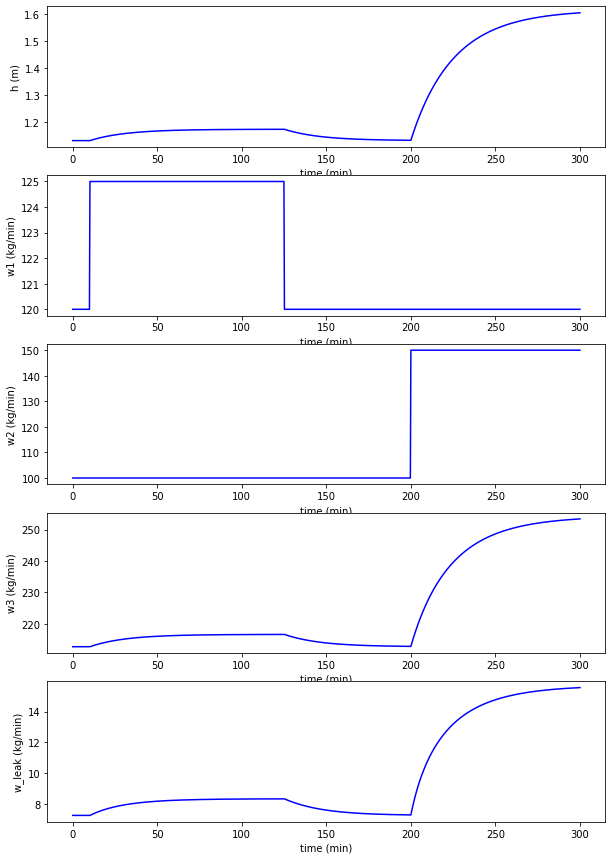

In [ ]:
yvalues = [h_array, MV_w1_array, MV_w2_array, w3_array, wleak_array] 
ylabels = ["h (m)", "w1 (kg/min)", "w2 (kg/min)", "w3 (kg/min)", "w_leak (kg/min)"]
markers = ["-b"]*len(yvalues)
colours = ["b"]*len(yvalues)
plot_function(t = tspan,
              y_values = yvalues,
              y_labels = ylabels,
              markers = markers,
              fig_size = (10,15))

# FOPDT Fitting

## FOPDT Functions:

In [ ]:
def FOPDT(t,KM,tau,theta): #define the time domain FOPDT function 
    """
    Calculates the response as a first order plus dead 
    time response.
    
    Parameters
    ----------
    t : array
        An array of time values.
        Units - [min]
            
    KM : Integer or float.
        The gain multiplied by the magnitude of the
        step change.
        Units - [kg/min]
    
    tau : Integer or float.
        The time constant.
        Units - [kg/min]
    
    theta : Integer or float.
        The dead time.
        Units - [min]
                
    Returns
    -------
    y: float
        The controlled variable of the system.
        Units - [depends on the variable]
    """
    theta = max(0,theta) # This is to ensure that theta >= 0
    tau = max(0,tau) # This is to ensure that tau >= 0
    
    # We need to recalculate the steady-state values to make the code more robust.
    y_ss_guess = [1.5]
    y_ss = scipy.optimize.fsolve(func = steady_state, 
                                 x0 = h_ss_guess)[0]  

    return y_ss + numpy.array([KM*(1-numpy.exp(-(t-theta)/tau)) if t >= theta else 0 for t in t])

def FOPDT_fitting(t, y0, M):
    """
    Fits the process data to a first order plus dead time model.
    
    Parameters
    ----------
    t : array
        An array of time values.
        Units - [min]
            
    y0 : An iterable object.
        The initial value of the controlled variable.
    
    M : Integer or float.
        The step change of the manipulated variable.
        
    Other Parameters
    ----------------
    y_FOPDT : array
        The actual process data of the system.
        Units - depends on the process
        
    y_max : Float
        The maximum value in y_FOPDT
        Units - depends on the process
    
    KM_guess : float
        The initial guess value for KM.
        Units - depends on y
        
    tau_guess: float
        The initial guess value for tau.
        Units - [min]
                
    Returns
    -------
    fitting paramaters: tuple
        The fitting parameters produced by the 
        scipy.optimize.curve_fit method.
        
        - K : float
            The process gain.
            Units - depends on the process
        
        - tau : float
            The process time constant
            Units - [min]
            
        - theta : 
            The process dead time
            Units - [min]    
    """
    y_FOPDT = solve_diff_equations(tspan = tspan,
                                   y0 = y0,
                                   fitting = True)[0]
    y_max = numpy.max(y_FOPDT)
    KM_guess = y_max - y0[0] # kg/min
    guessing = True
    
    while guessing:
        
        tau_guess = float(input("Guess the value of tau in minutes:")) # min
        theta_guess = float(input("Guess the value of theta in minutes:")) # min
        response_guess = FOPDT(t = tspan,
                               KM = KM_guess,
                               tau = tau_guess,
                               theta = theta_guess)
        
        title = "FOPDT model with guessing parameters"
        plot_function(t = tspan,
                      y_values = [y_FOPDT, response_guess],
                      y_labels = ["h (m)"], 
                      markers = ["b*", "g-"],
                      labels = ["Data", "Model"],
                      titles = title,
                      subplot = False)
        reply = True
        
        while reply:
        
            reply = input("Are you happy with your initial guesses? (Y/N)")
        
            if reply == "y" or reply == "Y":
                reply = False
                guessing = False
            
            elif reply == "N" or reply == "n":
                reply = False
                plt.close()


    params, cov =  scipy.optimize.curve_fit(f = FOPDT,
                                        xdata = tspan,
                                        ydata = y_FOPDT,
                                        p0 = [KM_guess, tau_guess, theta_guess])

    KM, tau , theta = params
    K = KM / M
    print("\nAfter using scipy.optimize.curve_fit:")
    print(f"KM = {round(KM,4)} kg/min")
    print(f"K = KM/M = {round(K,4)} kg/min")
    print(f"tau = {round(tau,1)} min")
    print(f"theta = {round(theta,1)} min/n")
    
    title = "FOPDT model with actual parameters"
    
    response = FOPDT(t = tspan, 
                     KM = KM,
                     tau = tau,
                     theta = theta)

    plot_function(t = tspan,
                  y_values = [y_FOPDT, response],
                  y_labels = ["h (m)"], 
                  markers = ["b*", "r-"],
                  labels = ["Data", "Model"],
                  titles = title,
                  subplot = False)
    
    return K, tau, theta

Fit the FOPDT model

In [ ]:
h_ss

1.1315282657727623

Guess the value of tau in minutes:30
Guess the value of theta in minutes:10


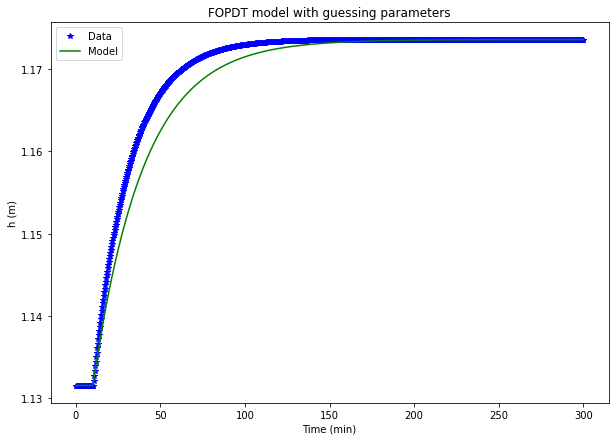

Are you happy with your initial guesses? (Y/N)y

After using scipy.optimize.curve_fit:
KM = 0.0421 kg/min
K = KM/M = 0.0084 kg/min
tau = 21.2 min
theta = 10.2 min/n


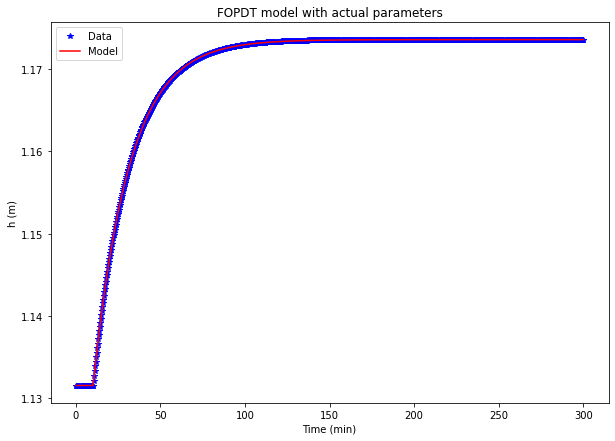

In [ ]:
# Define M:
M = 5 # kg/min

# Fit the parameters
K, tau, theta = FOPDT_fitting(t = tspan, 
                              y0 = [h_ss], 
                              M = M)

# Controller1

### For P control:

$$G_c = K_c$$

### For PI control:

$$G_c = K_c(1 + \frac{1}{\tau_I}) = \frac{K_C\tau_Is + K_C}{\tau_Is}$$

### For PD control:
- assumed that K_c_PD = K_c_PID (for now)
- assumed that tau_D_PD = tau_D_PID (for now)

$$G_c = K_c(1+\frac{\tau_Ds}{\alpha\tau_Ds+1}) = \frac{(K_C\tau_D\alpha+K_c\tau_D) s + K_c}{\tau_D\alpha s+1}$$

## PID control(realisable):
- found on table 8.1 (this is for stable and realisable)

$$G_c = K_c(1 + \frac{1}{\tau_Is}+\frac{\tau_Ds}{\alpha\tau_Ds+1}) = \frac{(K_C\tau_I\tau_D\alpha+K_c\tau_I\tau_D) s^2 +(K_c\tau_I+K_c\tau_D\alpha) s+K_c}{\tau_Is\tau_D\alpha s^2+\tau_Is}$$


## Controller functions:

In [ ]:
def controller_settings_solver(mode, tau_c, K, tau, theta, alpha = 0.1):
    """
    Calculates the tuning parameters of the controller using the IMC tuning 
    relations in table 12.1 in Seborg.
    
    Parameters
    ----------
    mode : string.
        Defines which mode the controller is operating in.
        
        Options:
        - "P" : Proportional control.
        - "PD" : Proportional - Derivative control.
        - "PI" : Proportional - Integral control.
        - "PID" : Proportional - Integral - Derivative control. 
            
    tau_c : Integer or float.
        The desired closed loop time caonstant.
        Units - [min]
    
    K : Integer or float.
        The process gain.
        Units - [Dimensionless]

    tau: Integer or float
        The process  time constant.
        Units - [min]

    theta: Integer or float.
        The process dead time.
        Units - [min]

    alpha: float.
        Derivative filter. Typical values for alpha range from 0.05 to 0.2, with
        0.1 being a common choice. 
        Reference: Chapter 8.2.3 in Seborg

        Default: 0.1
        
    Other Parameters
    ----------------
    numerator : list.
        The numerator terms of the transfer function G_c.
        
    denominator : list.
        The denominator terms of the transfer function G_c.
               
    Returns
    -------
    G_c : scipy.signal.ltisys.StateSpaceContinuous
        The controller transfer function in the state-space form.
        
    K_c : float.
        The controller gain.
        Units - [Dimensionless]
    
    tau_I : float.
        The integral time constant
        Units - [min]
        
    tau_D : float.
        The derivative time constant
        Units - [min]
    """
    if mode == 'P': #just assumed for now can use any suitable relationship
        K_c = tau / (tau_c + theta) / K
        tau_D = 0
        tau_I = 0
        numerator = [0, K_c]
        denominator = [0, 1]
    
    elif mode == 'PI':
        K_c = tau / (tau_c + theta) / K
        tau_I = tau
        tau_D = 0
        numerator = [K_c*tau_I, K_c]
        denominator = [tau_I, 0] 
    
    elif mode=='PID':

        K_c = (tau + theta / 2) / (tau_c + theta / 2) / K
        tau_I = tau + theta / 2
        tau_D = tau*theta / (2 * tau + theta)
        
        numerator = [K_c * tau_I * tau_D * alpha + K_c * tau_I * tau_D,
                     K_c * tau_I + K_c * tau_D * alpha, K_c] 
        denominator = [tau_I * tau_D * alpha, tau_I, 0]

    elif mode=='PD':
        K_c = (tau + theta / 2) / (tau_c + theta / 2) / K
        tau_I = 0
        tau_D = tau*theta / (2 * tau + theta)
        
        numerator = [K_c * alpha * tau_D + K_c * tau_D, K_c]
        denominator = [alpha * tau_D, 1] 
    
    Gc = scipy.signal.lti(numerator, denominator).to_ss()
    
    return Gc, K_c, tau_I, tau_D


def ysp(t):
    """
    The set point of the controlled variable as a function of time. This funtion
    can be alter too achieve the desired set point level.
    
    Parameters
    ----------
    t : float.
        Time.
        Units - [min]
        
    Returns
    -------
    y_sp : float or integer
        The set point of the controlled variable.
    """
    if t < 50:
        return y_ss
    
    if t >= 50:
        return 1.5

def controller(tspan, tau_c, K, tau, theta, alpha = 0.1, mode = "PID"):
    """
    This is the controller function. It controls the set point of the 
    controlled variable by changing the manipulated variable.
    
    Parameters
    ----------
    tspan : An iterable object.
        An array of time values.
        Units - [min]
            
    tau_c : Integer or float.
        The desired closed loop time caonstant.
        Units - [min]
    
    K : Integer or float.
        The process gain.
        Units - [Dimensionless]

    tau: Integer or float
        The process  time constant.
        Units - [min]

    theta: Integer or float.
        The process dead time.
        Units - [min]

    alpha: float.
        Derivative filter. Typical values for alpha range from 0.05 to 0.2, with
        0.1 being a common choice. 
        Reference: Chapter 8.2.3 in Seborg

        Default: 0.1

    mode : string.
        Defines which mode the controller is operating in.
        Default: "PID"

        Options:
        - "P" : Proportional control.
        - "PD" : Proportional - Derivative control.
        - "PI" : Proportional - Integral control.
        - "PID" : Proportional - Integral - Derivative control.

        
        
    Other Parameters
    ----------------
    numerator : list.
        The numerator terms of the transfer function G_c.
        
    denominator : list.
        The denominator terms of the transfer function G_c.
               
    Returns
    -------
    hc_array : list.
        The values of the controlled variable.
        
    w1_array : list.
        The values of the manipulated variable.
    """
    
    Gc, K_c, tau_I, tau_D = controller_settings_solver(mode = mode,
                                                       tau_c = tau_c,
                                                       K = K, 
                                                       tau = tau, 
                                                       theta = theta, 
                                                       alpha = alpha)
    
    w10 = w1_ss # The bias assumed to be the steady state value.
    w1_array = [] # kg/min
    h = h_ss # Assume h is initially at steady state
    hc_array = [] # This is the array of h values calculated during the control process

    xc = numpy.zeros([Gc.A.shape[0], 1]) # This is the initial controller output assumed to be 0

    dt = tspan[1] - tspan[0] # This is the time step

    for t in tspan:
        error = ysp(t) - h # This is the error of the system

        dxcdt = Gc.A.dot(xc) + Gc.B.dot(error) # This is from the state-space representation: x^dot = Ax + Bu
        yc = Gc.C.dot(xc) + Gc.D.dot(error) # This is from the state-space representation: y = Cx + Du
        
        
        w1 = w10 + yc[0, 0] # The new value of w1 must be the initial w1 value + the output of the controller
        
        if w1 >= w1max:
            w1 = w1max
        
        elif w1 <= 0:
            w1 = 0
            
            
        w2 = MV_w2(t) # w2 is a function of time (in this case, it is constant)
        dhdt = (1/ (rho * A)) * (w1 + w2 - w_leak(h) - w3(h)) # The differential equation of h
        h += dhdt*dt # Euler integration
        xc += dxcdt*dt # Euler integration

        hc_array.append(h)
        w1_array.append(w1)
        
    return hc_array, w1_array

## Controller responses:

In [ ]:
# Define tau_c:
tau_c = theta # Dafault value by Grinholt and Skogestad (2013) 
              # [Table 12.3 in  Seborg]
w1max = 1.5*w1_ss # Maximum saturation limit of manipulated  variable
w1min = 0 # Minimum saturation limit  of manipulated  variable
modes = ["PI", "PD", "PID", "P"]
y_ss = h_ss

# Storage space
h_sp_array = numpy.array(list(map(ysp, tspan)))
w2_array = numpy.array(list(map(MV_w2, tspan)))

hc_mat, w1_mat, w3_mat, wleak_mat = [h_sp_array], [w2_array], [], []  

# Calculate the responses of the controller for each mode.
for mode in modes:
    hc_array, w1_array = controller(tspan = tspan, 
                                    tau_c = tau_c, 
                                    K = K, 
                                    tau = tau, 
                                    theta = theta, 
                                    mode = mode)
    
    w3_array = numpy.array(list(map(w3, hc_array)))
    wleak_array = numpy.array(list(map(w_leak, hc_array)))
    
    hc_mat.append(hc_array)
    w1_mat.append(w1_array)
    w3_mat.append(w3_array)
    wleak_mat.append(wleak_array)


/usr/local/lib/python3.7/dist-packages/scipy/signal/filter_design.py:1622: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


At t = 50 min, there is a step change in the set point from the steady state height to 1.5 m. At t = 200 min, the flowrate of w2 goes steps from 100 kg/min to 150 kg/min.

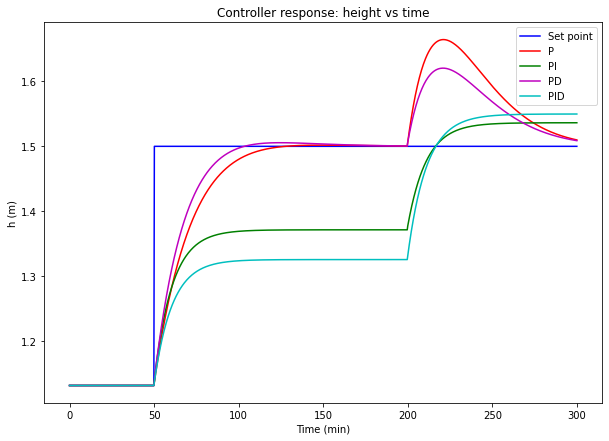

In [ ]:
markers = ["b-", "r-", "g-", "m-", "c-"]
labels = ["Set point", "P", "PI", "PD", "PID"]

plot_function(t = tspan,
              y_values = hc_mat,
              y_labels = ["h (m)"],
              markers = markers,
              labels = labels,
              titles = "Controller response: height vs time",
              fig_size = (10, 7),
              subplot = False)

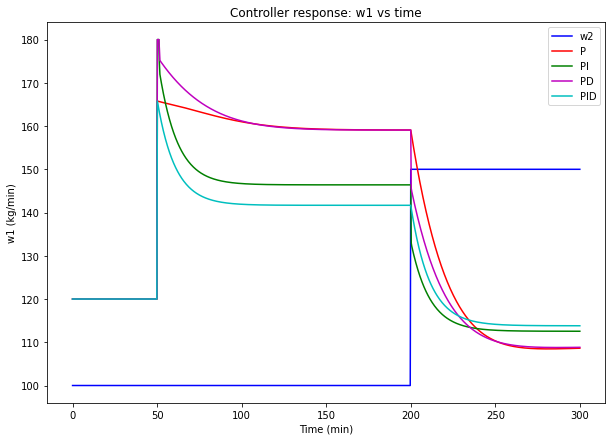

In [ ]:
markers = ["b-", "r-", "g-", "m-", "c-"]
labels = ["w2","P", "PI", "PD", "PID", ]

plot_function(t = tspan,
              y_values = w1_mat,
              y_labels = ["w1 (kg/min)"],
              markers = markers,
              labels = labels,
              titles = "Controller response: w1 vs time",
              fig_size = (10, 7),
              subplot = False)


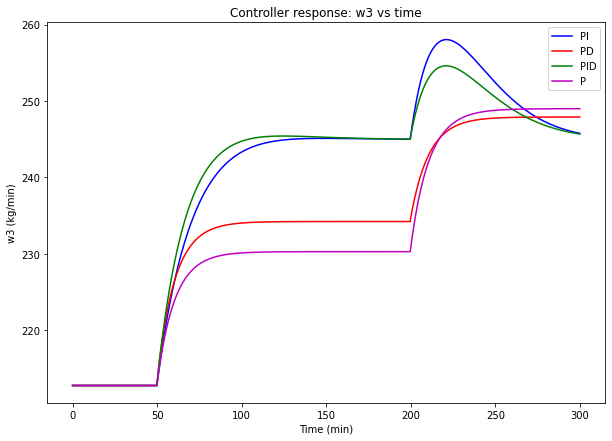

In [ ]:
plot_function(t = tspan,
              y_values = w3_mat,
              y_labels = ["w3 (kg/min)"],
              markers = markers,
              labels = modes,
              titles = "Controller response: w3 vs time",
              fig_size = (10, 7),
              subplot = False)

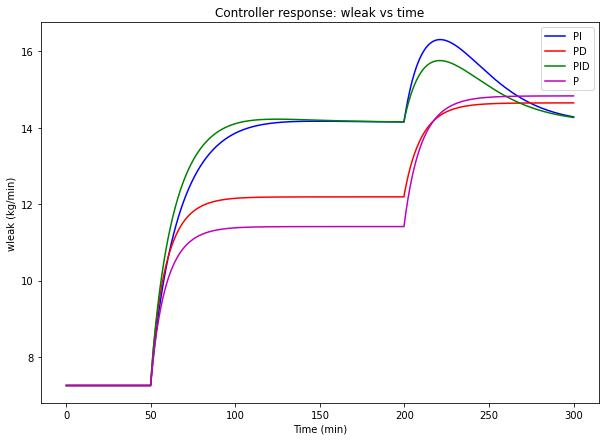

In [ ]:
plot_function(t = tspan,
              y_values = wleak_mat,
              y_labels = ["wleak (kg/min)"],
              markers = markers,
              labels = modes,
              titles = "Controller response: wleak vs time",
              fig_size = (10, 7),
              subplot = False)